In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

BATCH_SIZE = 64
EPOCHS = 45
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DATA_DIR = "./filtered_data"
CLASSES = ["dog_images", "hamster_images", "bear_images", "penguin_images", "dolphin_images", "flamingo_images"]

transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

full_class_counts = Counter([label for _, label in full_dataset])
print("Full dataset class distribution:", full_class_counts)

train_class_counts = Counter([label for _, label in train_dataset])
print("Train dataset class distribution:", train_class_counts)

val_class_counts = Counter([label for _, label in val_dataset])
print("Validation dataset class distribution:", val_class_counts)

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d(kernel_size=3, stride=3)
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Name of current CUDA device:NVIDIA GeForce RTX 3050 Laptop GPU
Full dataset class distribution: Counter({1: 326, 5: 284, 0: 256, 2: 192, 3: 188, 4: 142})
Train dataset class distribution: Counter({1: 275, 5: 233, 0: 198, 3: 149, 2: 147, 4: 108})
Validation dataset class distribution: Counter({0: 58, 5: 51, 1: 51, 2: 45, 3: 39, 4: 34})


{0: 5.421875, 1: 4.257668711656442, 2: 7.229166666666667, 3: 7.382978723404255, 4: 9.774647887323944, 5: 4.887323943661972}
Epoch 1/45, Train Loss: 27.5683, Train Accuracy: 0.3883, Val Loss: 8.3830, Val Accuracy: 0.2806, Learning Rate: 0.00010000
Epoch 2/45, Train Loss: 18.3227, Train Accuracy: 0.6117, Val Loss: 6.8751, Val Accuracy: 0.4065, Learning Rate: 0.00022667
Epoch 3/45, Train Loss: 16.7558, Train Accuracy: 0.6432, Val Loss: 5.6394, Val Accuracy: 0.4784, Learning Rate: 0.00035333
Epoch 4/45, Train Loss: 15.3667, Train Accuracy: 0.6703, Val Loss: 4.8490, Val Accuracy: 0.5504, Learning Rate: 0.00048000
Epoch 5/45, Train Loss: 11.4725, Train Accuracy: 0.7378, Val Loss: 7.0150, Val Accuracy: 0.5072, Learning Rate: 0.00060667
Epoch 6/45, Train Loss: 12.5865, Train Accuracy: 0.7090, Val Loss: 4.9018, Val Accuracy: 0.6871, Learning Rate: 0.00073333
Epoch 7/45, Train Loss: 11.5294, Train Accuracy: 0.7766, Val Loss: 4.4025, Val Accuracy: 0.6619, Learning Rate: 0.00086000
Epoch 8/45, Tra

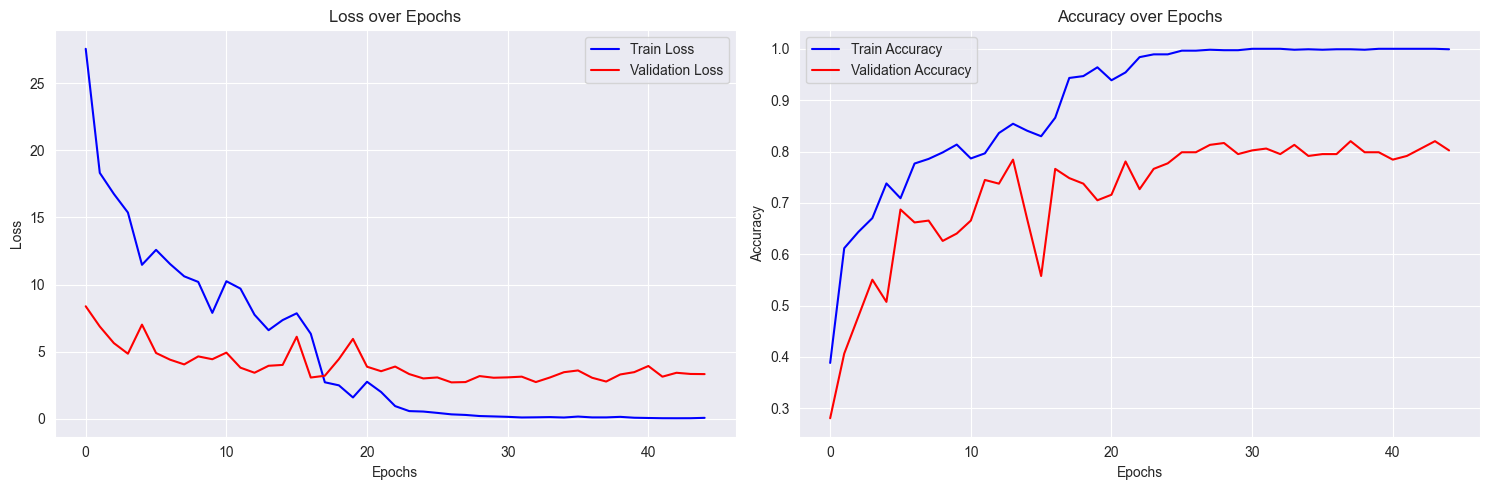


Classification Report for Training Set:
                 precision    recall  f1-score   support

    bear_images       1.00      1.00      1.00       198
     dog_images       1.00      1.00      1.00       275
 dolphin_images       1.00      1.00      1.00       147
flamingo_images       1.00      1.00      1.00       149
 hamster_images       1.00      1.00      1.00       108
 penguin_images       1.00      1.00      1.00       233

       accuracy                           1.00      1110
      macro avg       1.00      1.00      1.00      1110
   weighted avg       1.00      1.00      1.00      1110



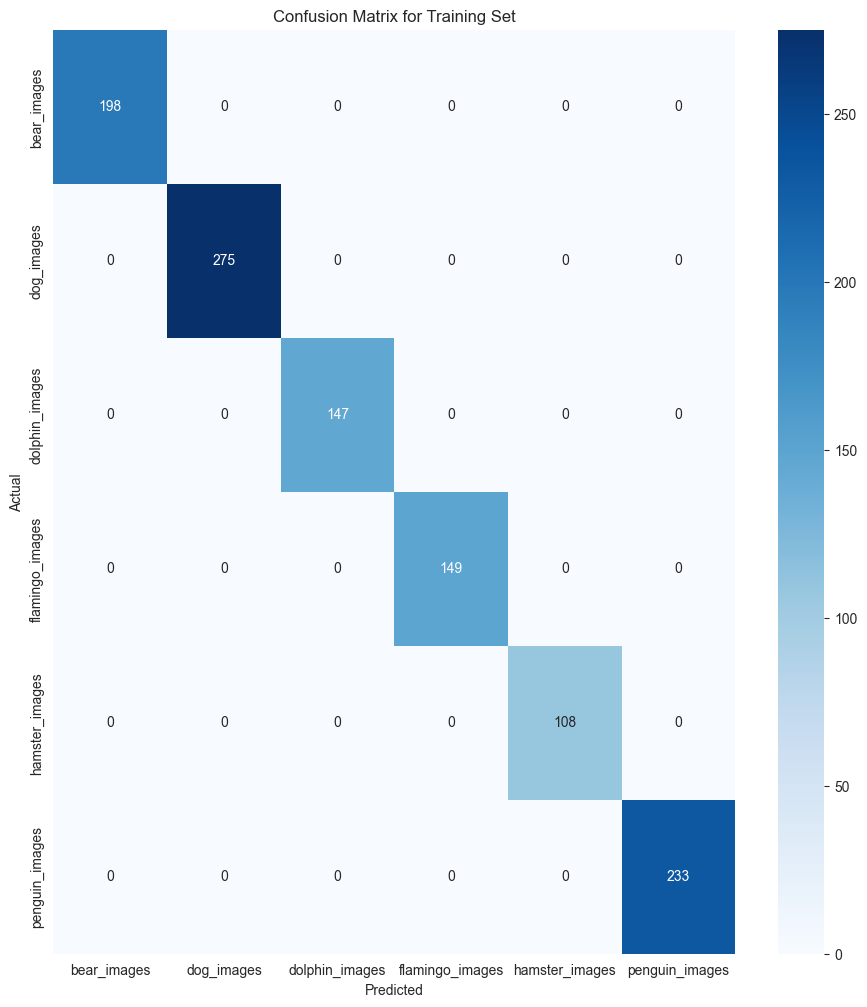


Classification Report for Validation Set:
                 precision    recall  f1-score   support

    bear_images       0.77      0.84      0.80        58
     dog_images       0.63      0.75      0.68        51
 dolphin_images       0.93      0.89      0.91        45
flamingo_images       0.94      0.79      0.86        39
 hamster_images       0.81      0.62      0.70        34
 penguin_images       0.85      0.86      0.85        51

       accuracy                           0.80       278
      macro avg       0.82      0.79      0.80       278
   weighted avg       0.81      0.80      0.80       278



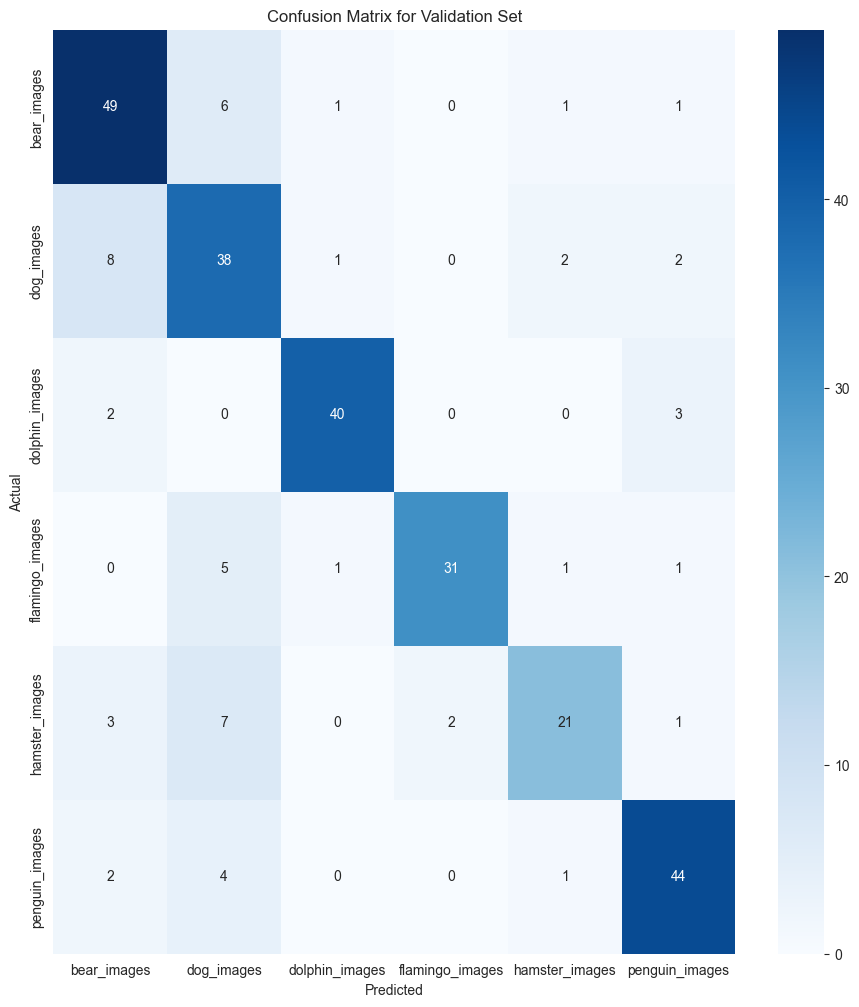

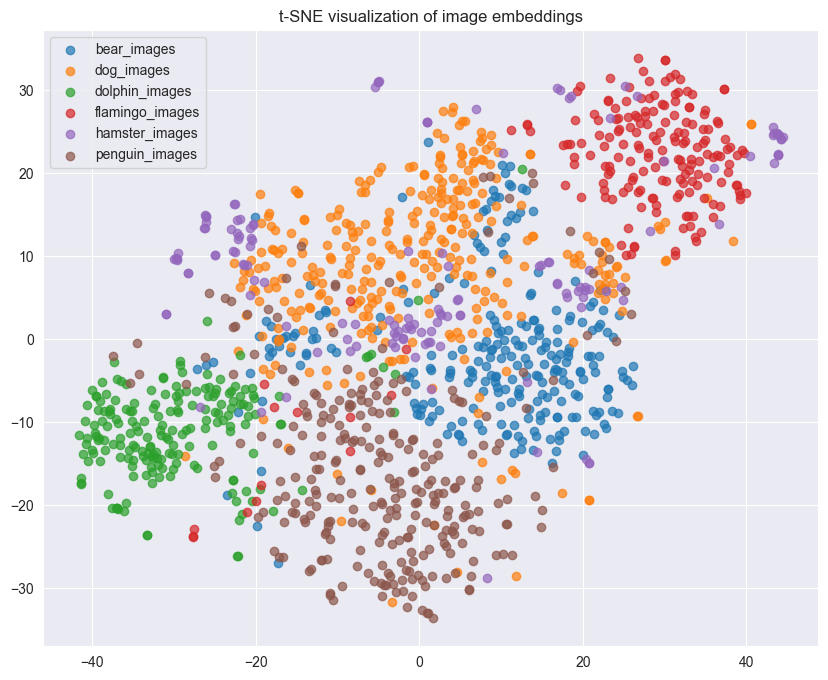

In [11]:
model = CNNModel(num_classes=num_classes).to(DEVICE)

class_counts = Counter([label for _, label in full_dataset])

total_samples = len(full_dataset)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
print(class_weights)

weights = torch.tensor([class_weights[cls] for cls in range(num_classes)], device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), weight_decay=2e-5)

writer = SummaryWriter("runs/cnn_training")

scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-4,
    max_lr=0.002,
    step_size_up=15,
    mode='triangular2'
)

def evaluate_model(model, loader, dataset_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(11, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(range(EPOCHS), train_losses, label="Train Loss", color='b')
    ax1.plot(range(EPOCHS), val_losses, label="Validation Loss", color='r')
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(range(EPOCHS), train_accuracies, label="Train Accuracy", color='b')
    ax2.plot(range(EPOCHS), val_accuracies, label="Validation Accuracy", color='r')
    ax2.set_title("Accuracy over Epochs")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()

def train_model():
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        train_correct = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_accuracy = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_accuracy = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        current_lr = optimizer.param_groups[0]['lr']

        writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
        writer.add_scalars("Accuracy", {"train": train_accuracy, "val": val_accuracy}, epoch)
        writer.add_scalar("Learning Rate", current_lr, epoch)

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {current_lr:.8f}")

        scheduler.step()

    writer.close()

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    evaluate_model(model, train_loader, "Training Set")
    evaluate_model(model, val_loader, "Validation Set")

train_model()

def extract_embeddings():
    embeddings = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False):
            images = images.to(DEVICE)
            features = model.conv_layers(images)
            features = features.view(features.size(0), -1).cpu().numpy()
            embeddings.append(features)
            labels_list.extend(labels.numpy())

    embeddings = np.vstack(embeddings)
    labels_list = np.array(labels_list)
    return embeddings, labels_list

def visualize_embeddings(embeddings, labels_list):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels_list):
        idx = labels_list == label
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=full_dataset.classes[label], alpha=0.7)

    plt.legend()
    plt.title("t-SNE visualization of image embeddings")
    plt.show()

embeddings, labels_list = extract_embeddings()
visualize_embeddings(embeddings, labels_list)

Name of current CUDA device:NVIDIA GeForce RTX 3050 Laptop GPU


C:\Users\n-i-k\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Train Loss: 27.3307, Train Accuracy: 0.4360, Val Loss: 5.4249, Val Accuracy: 0.8022
Epoch 2/40, Train Loss: 18.1208, Train Accuracy: 0.7856, Val Loss: 3.5849, Val Accuracy: 0.8813
Epoch 3/40, Train Loss: 12.1484, Train Accuracy: 0.8631, Val Loss: 2.7079, Val Accuracy: 0.8669
Epoch 4/40, Train Loss: 8.8626, Train Accuracy: 0.8703, Val Loss: 2.1089, Val Accuracy: 0.9029
Epoch 5/40, Train Loss: 7.1572, Train Accuracy: 0.9153, Val Loss: 1.6885, Val Accuracy: 0.8921
Epoch 6/40, Train Loss: 5.9786, Train Accuracy: 0.9036, Val Loss: 1.5812, Val Accuracy: 0.9029
Epoch 7/40, Train Loss: 5.1509, Train Accuracy: 0.9279, Val Loss: 1.4457, Val Accuracy: 0.8993
Epoch 8/40, Train Loss: 4.7215, Train Accuracy: 0.9270, Val Loss: 1.3912, Val Accuracy: 0.9029
Epoch 9/40, Train Loss: 4.1942, Train Accuracy: 0.9360, Val Loss: 1.2065, Val Accuracy: 0.8993
Epoch 10/40, Train Loss: 4.2425, Train Accuracy: 0.9324, Val Loss: 1.1707, Val Accuracy: 0.9101
Epoch 11/40, Train Loss: 3.6160, Train Accurac

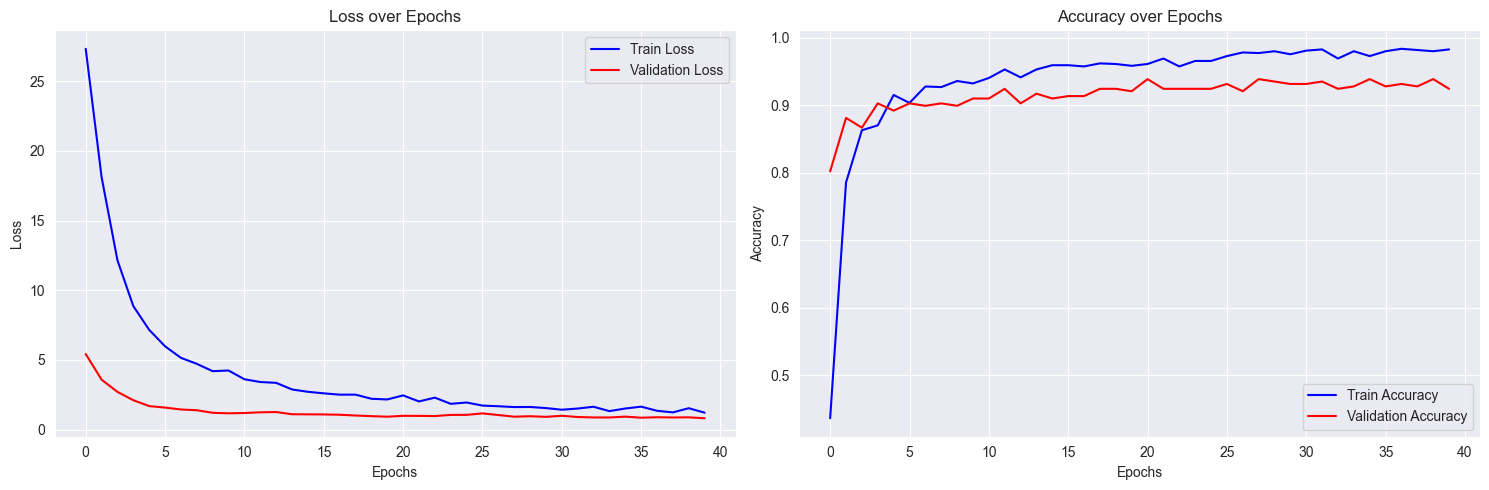


Classification Report for Training Set:
                 precision    recall  f1-score   support

    bear_images       1.00      1.00      1.00       201
     dog_images       1.00      0.99      0.99       251
 dolphin_images       0.97      1.00      0.98       164
flamingo_images       1.00      1.00      1.00       144
 hamster_images       1.00      1.00      1.00       116
 penguin_images       1.00      0.98      0.99       234

       accuracy                           0.99      1110
      macro avg       0.99      0.99      0.99      1110
   weighted avg       0.99      0.99      0.99      1110



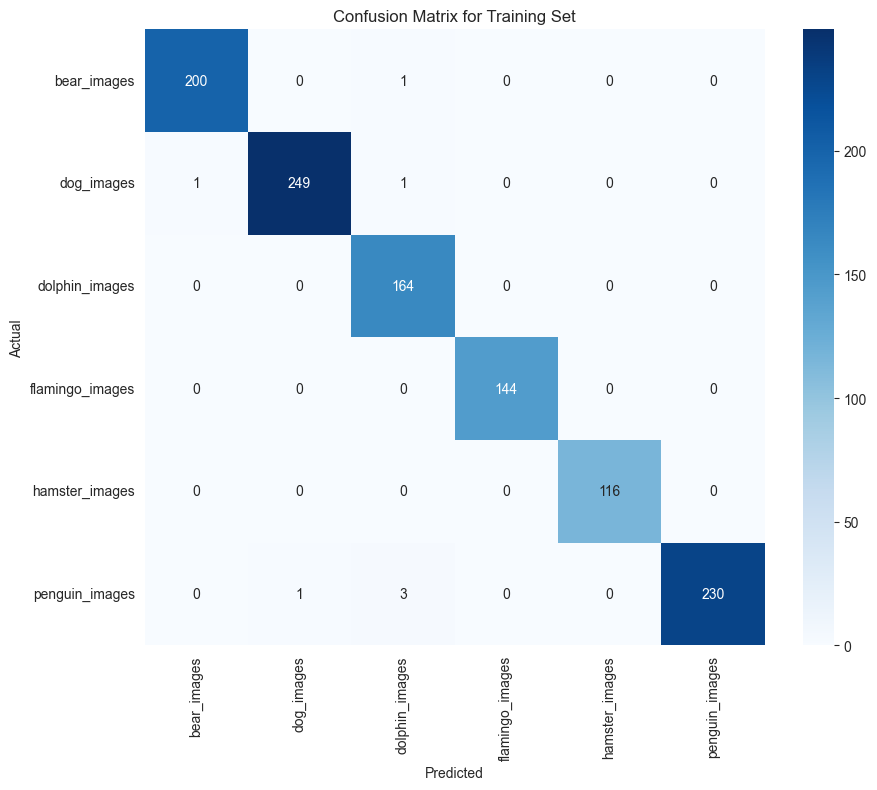


Classification Report for Validation Set:
                 precision    recall  f1-score   support

    bear_images       0.91      0.89      0.90        55
     dog_images       0.92      0.91      0.91        75
 dolphin_images       0.90      0.96      0.93        28
flamingo_images       1.00      0.98      0.99        44
 hamster_images       0.86      0.96      0.91        26
 penguin_images       0.94      0.90      0.92        50

       accuracy                           0.92       278
      macro avg       0.92      0.93      0.93       278
   weighted avg       0.93      0.92      0.92       278



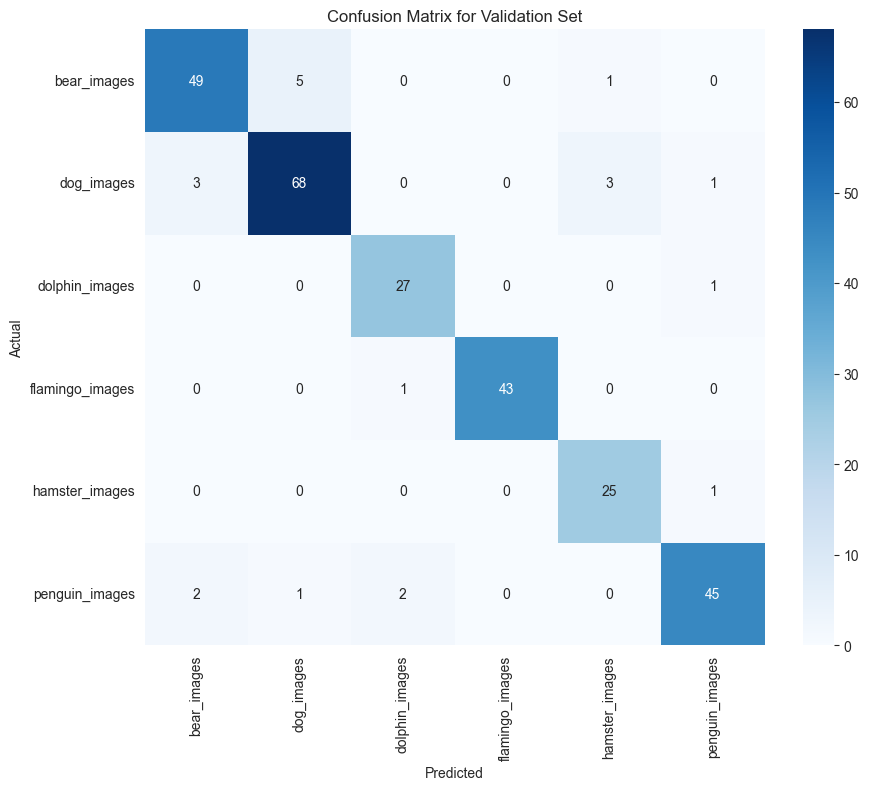

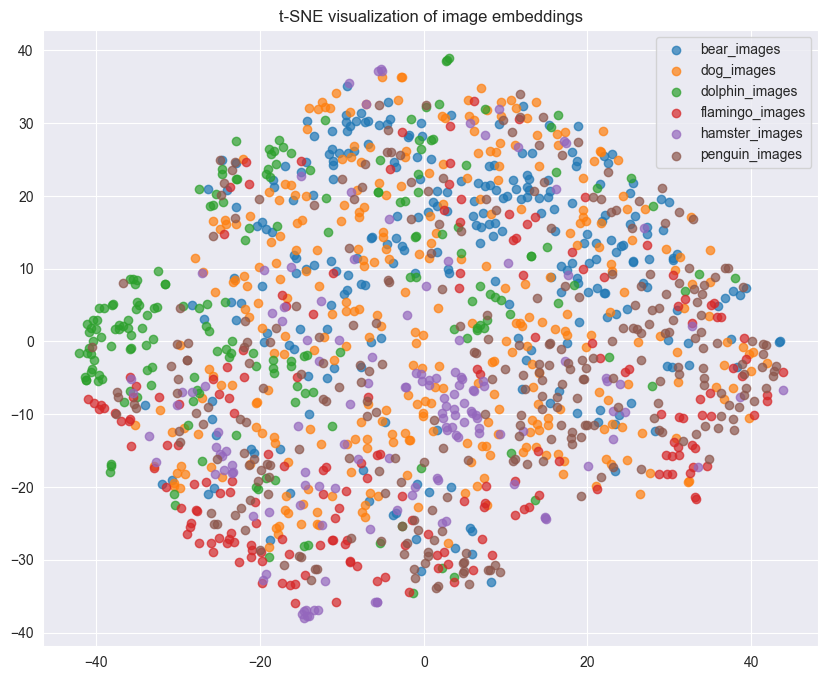

In [9]:
from torchvision import models

BATCH_SIZE = 64
EPOCHS = 40
LEARNING_RATE = 0.0002
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda_id = torch.cuda.current_device()
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DATA_DIR = "./filtered_data"
CLASSES = ["dog_images", "hamster_images", "bear_images", "penguin_images", "dolphin_images", "flamingo_images"]

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
num_classes = len(full_dataset.classes)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

class TransferLearningModel(nn.Module):
    def __init__(self, num_classes):
        super(TransferLearningModel, self).__init__()
        self.resnet = models.resnet18(weights=True)

        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(
            nn.Linear(self.resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

model = TransferLearningModel(num_classes=num_classes).to(DEVICE)

class_counts = Counter([label for _, label in full_dataset])

total_samples = len(full_dataset)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = torch.tensor([class_weights[cls] for cls in range(num_classes)], device=DEVICE)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

writer = SummaryWriter("runs/transfer_learning")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3)

def evaluate_model(model, loader, dataset_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes,
                yticklabels=full_dataset.classes)
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(range(EPOCHS), train_losses, label="Train Loss", color='b')
    ax1.plot(range(EPOCHS), val_losses, label="Validation Loss", color='r')
    ax1.set_title("Loss over Epochs")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(range(EPOCHS), train_accuracies, label="Train Accuracy", color='b')
    ax2.plot(range(EPOCHS), val_accuracies, label="Validation Accuracy", color='r')
    ax2.set_title("Accuracy over Epochs")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()
    plt.show()


def train_model():
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        train_correct = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_accuracy = train_correct / len(train_dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_accuracy = val_correct / len(val_dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        writer.add_scalars("Loss", {"train": train_loss, "val": val_loss}, epoch)
        writer.add_scalars("Accuracy", {"train": train_accuracy, "val": val_accuracy}, epoch)

        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    writer.close()

    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    evaluate_model(model, train_loader, "Training Set")
    evaluate_model(model, val_loader, "Validation Set")

train_model()

def extract_embeddings():
    embeddings = []
    labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False):
            images = images.to(DEVICE)
            features = model.resnet.conv1(images)
            features = model.resnet.layer1(features)
            features = model.resnet.layer2(features)
            features = model.resnet.layer3(features)
            features = model.resnet.layer4(features)
            features = model.resnet.avgpool(features)
            features = features.view(features.size(0), -1).cpu().numpy()
            embeddings.append(features)
            labels_list.extend(labels.numpy())

    embeddings = np.vstack(embeddings)
    labels_list = np.array(labels_list)
    return embeddings, labels_list


def visualize_embeddings(embeddings, labels_list):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    for label in np.unique(labels_list):
        idx = labels_list == label
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=full_dataset.classes[label], alpha=0.7)

    plt.legend()
    plt.title("t-SNE visualization of image embeddings")
    plt.show()

embeddings, labels_list = extract_embeddings()
visualize_embeddings(embeddings, labels_list)
